# Predatory Journals

Gets top cited articles from potential predatory journals


In [ ]:
!pip install pandas
!pip install orjson

In [23]:
import orjson
import pandas as pd
from banal import ensure_dict
import requests
import os

## Define helper functions

In [24]:
# Get OpenAlex json
def get_json(*args, **kwargs):
    res = requests.get(*args, **kwargs)
    assert res.ok
    return res.json()

In [25]:
# Extract properties from Openalex API objects with nested dictionaries
def extract(obj, *paths):
    paths = list(paths)
    for p in paths[:-1]:
        obj = ensure_dict(obj.get(p))
    return obj.get(paths[-1])

## Load journal list

It's difficult to categorize a journal as predatory journal as there are different critiera and the actual publication process can vary from the peer review process which is promised on the journal website.

Lists of potential predatory journals exists, but are also critized. Therefore, before any accusation or publication, validate the list of analyzed journals.

For more detail, have a look at the following resources:

 - [Predatory Journals](https://predatoryjournals.org/)
 - [Beall's List](https://beallslist.net/)
 - [Chinese Early Warning List](https://earlywarning.fenqubiao.com/)

For the purpose of this Jupyter notebook we use a small sample of journals of the first list to show the general steps for investigation.


In [49]:
# Create the DataFrame with the provided information
data = {
    "warnlist__name": ["Abstract and Applied Analysis", "Academic Exchange Quarterly", "Adalya Journal", "HCTL Open International Journal of Technology Innovations and Research", "Journal of Pharmacology and Pharmacotherapeutics", "Professionals Center for Business Research"],
    "warnlist__url": [
        "https://www.hindawi.com/journals/aaa/", 
        "http://www.rapidintellect.com/AEQweb/", 
        "http://adalyajournal.com/",
        "http://ijtir.hctl.org/",
        "http://www.jpharmacol.com/",
        "http://pcbr.net/"
    ],
    "warnlist__additional_info": ["", "", "hijacker of a legitimate journal", "", "published by Medknow", ""],
}

warn_list = pd.DataFrame(data)
warn_list.head()

,warnlist__name,warnlist__url,warnlist__additional_info
0,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,
1,Academic Exchange Quarterly,http://www.rapidintellect.com/AEQweb/,
2,Adalya Journal,http://adalyajournal.com/,hijacker of a legitimate journal
3,HCTL Open International Journal of Technology ...,http://ijtir.hctl.org/,
4,Journal of Pharmacology and Pharmacotherapeutics,http://www.jpharmacol.com/,published by Medknow


## Define function to get journal and article information

In [50]:
SOURCE_URL = "https://api.openalex.org/sources"
JOURNAL_COLS = ['id', 'issn', 'display_name', 'works_count', 'country_code', 'cited_by_count', 'works_api_url']
ARTICLE_COLS = ["id", "doi", "title", "publication_year", "publication_date", "oa_url", "cited_by_count", "location_count", "is_retracted"]

BASE_PARAMS = {
    "per_page": 100,
    "page": 1,
    "sort": "cited_by_count:desc",
}


def get_top_articles_in_journal(warnlist_info={}):
    
    # Get OA journal data based on ISSN
    issn = warnlist_info.get('warnlist__issn', None)
    if issn:
        url = SOURCE_URL + f'/issn:{issn}'
    else:
        name = warnlist_info.get('warnlist__name').replace(' ', '%20')
        url = SOURCE_URL + f'?filter=display_name.search:{name}'
    print(url)
    journal_resp = get_json(url)
    
    if journal_resp['results'] == []:
        return 
    
    else:
        journal_resp = journal_resp['results'][0]
        journal_data = {f"journal__{k}": v for k, v in journal_resp.items() if k in JOURNAL_COLS}
    
        # Get 100 most cited articles from journal
        articles_resp = get_json(journal_resp['works_api_url'], params=BASE_PARAMS)
    
        articles = articles_resp["results"]
        if not articles:
            return
            
        # get metadata for each article
        for article in articles:
            article_data = {f"article__{k}": v for k, v in article.items() if k in ARTICLE_COLS}
            article_data["article__journal"] = extract(article, "primary_location", "source", "display_name")
            article_data["article__primary_topic"] = extract(article, "primary_topic", "display_name")
            article_data["article__primary_field"] = extract(article, "primary_topic", "field", "display_name")

            # Get authors and institutions
            for authorship in article["authorships"]:
                author = {f"author__{k}": v for k, v in authorship["author"].items()}
                for institution in authorship["institutions"]:
                    institution = {f"institution__{k}": v for k, v in institution.items() if k != 'lineage'}
                    yield {**warnlist_info, **journal_data, **article_data, **author, **institution}

## Get the top cited articles of each journal

In [51]:
df = pd.DataFrame()
for idx, journal in warn_list.iterrows():
    print(journal['warnlist__name'])
    try:
        df = pd.concat([df, pd.DataFrame(get_top_articles_in_journal(journal.to_dict()))])
    except Exception as e:
        print(e)

Abstract and Applied Analysis
https://api.openalex.org/sources?filter=display_name.search:Abstract%20and%20Applied%20Analysis
Academic Exchange Quarterly
https://api.openalex.org/sources?filter=display_name.search:Academic%20Exchange%20Quarterly
Adalya Journal
https://api.openalex.org/sources?filter=display_name.search:Adalya%20Journal
HCTL Open International Journal of Technology Innovations and Research
https://api.openalex.org/sources?filter=display_name.search:HCTL%20Open%20International%20Journal%20of%20Technology%20Innovations%20and%20Research
Journal of Pharmacology and Pharmacotherapeutics
https://api.openalex.org/sources?filter=display_name.search:Journal%20of%20Pharmacology%20and%20Pharmacotherapeutics
Professionals Center for Business Research
https://api.openalex.org/sources?filter=display_name.search:Professionals%20Center%20for%20Business%20Research


Frontiers in Toxicology
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Toxicology
Frontiers in Transplantation
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Transplantation
Frontiers in Tropical Diseases
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Tropical%20Diseases
Frontiers in Urology
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Urology
Frontiers in Veterinary Science
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Veterinary%20Science
Frontiers in Virology
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Virology
Frontiers in Virtual Reality
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Virtual%20Reality
Frontiers in Water
https://api.openalex.org/sources?filter=display_name.search:Frontiers%20in%20Water
Fuels
https://api.openalex.org/sources?filter=display_name.search:Fu


Global Media Journal
https://api.openalex.org/sources?filter=display_name.search:Global%20Media%20Journal
Global Scholastic Research Journal
https://api.openalex.org/sources?filter=display_name.search:Global%20Scholastic%20Research%20Journal
Global Scientific Journal – GSJ Publication
https://api.openalex.org/sources?filter=display_name.search:Global%20Scientific%20Journal%20–%20GSJ%20Publication
Golden Research Thoughts
https://api.openalex.org/sources?filter=display_name.search:Golden%20Research%20Thoughts
Gout, Urate, and Crystal Deposition Disease
https://api.openalex.org/sources?filter=display_name.search:Gout,%20Urate,%20and%20Crystal%20Deposition%20Disease

Graphene
https://api.openalex.org/sources?filter=display_name.search:Graphene
Grasses
https://api.openalex.org/sources?filter=display_name.search:Grasses
Green and Sustainable Chemistry
https://api.openalex.org/sources?filter=display_name.search:Green%20and%20Sustainable%20Chemistry
Hardware
https://api.openalex.org/sources?

Indo American Journal of Pharmaceutical Sciences
https://api.openalex.org/sources?filter=display_name.search:Indo%20American%20Journal%20of%20Pharmaceutical%20Sciences
Indo-Global Journal of Pharmaceutical Sciences
https://api.openalex.org/sources?filter=display_name.search:Indo-Global%20Journal%20of%20Pharmaceutical%20Sciences
Indonesian Journal of Business Finance and Accounting
https://api.openalex.org/sources?filter=display_name.search:Indonesian%20Journal%20of%20Business%20Finance%20and%20Accounting
Indonesian Journal of Management and Business Economics
https://api.openalex.org/sources?filter=display_name.search:Indonesian%20Journal%20of%20Management%20and%20Business%20Economics
Indoor Air
https://api.openalex.org/sources?filter=display_name.search:Indoor%20Air
Industrial Science Journal
https://api.openalex.org/sources?filter=display_name.search:Industrial%20Science%20Journal
Infectious Disease Reports
https://api.openalex.org/sources?filter=display_name.search:Infectious%20Dise

International Journal for Pharmaceutical Research Scholars
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20for%20Pharmaceutical%20Research%20Scholars
International Journal for Research & Development in Technology
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20for%20Research%20&%20Development%20in%20Technology

International Journal for Research in Applied Science and Engineering Technology
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20for%20Research%20in%20Applied%20Science%20and%20Engineering%20Technology
International Journal for Research in Emerging Science and Technology
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20for%20Research%20in%20Emerging%20Science%20and%20Technology
International Journal for Research in Engineering Application & Management
https://api.openalex.org/sources?filter=display_name.search:International%20Jour


International Journal of Advanced Research in Computer and Communication Engineering
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Advanced%20Research%20in%20Computer%20and%20Communication%20Engineering
International Journal of Advanced Research in Computer Engineering & Technology
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Advanced%20Research%20in%20Computer%20Engineering%20&%20Technology

International Journal of Advanced Research in Computer Science & Technology
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Advanced%20Research%20in%20Computer%20Science%20&%20Technology

International Journal of Advanced Research in Computer Science and Electronics Engineering
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Advanced%20Research%20in%20Computer%20Science%20and%20Electronics%20Engineering
International Journ

International Journal of Aerospace Engineering
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Aerospace%20Engineering
International Journal of Agricultural Sciences and Veterinary Medicine
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Agricultural%20Sciences%20and%20Veterinary%20Medicine
International Journal of Agricultural, Forestry & Plantation
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Agricultural,%20Forestry%20&%20Plantation

International Journal of Agriculture and Biosciences
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Agriculture%20and%20Biosciences
International Journal of Agriculture and Crop Sciences
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Agriculture%20and%20Crop%20Sciences
International Journal of Agriculture and Environmental Research
https

International Journal of Basic Sciences and Applied Research
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Basic%20Sciences%20and%20Applied%20Research
International Journal of Bio
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Bio
International Journal of Bioassays
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Bioassays
International Journal of Biological & Pharmaceutical Research
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Biological%20&%20Pharmaceutical%20Research

International Journal of Biological and Chemical Sciences
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Biological%20and%20Chemical%20Sciences
International Journal of Biology, Pharmacy and Allied Sciences
https://api.openalex.org/sources?filter=display_name.search:International%20Journal%20of%20Biolo

## Clean Data

In [52]:
df = df[df['warnlist__name'] == df['journal__display_name']]

In [53]:
def join_list_column(df, column_name, separator=", "):
    """
    Convert a list stored in a DataFrame column into a string with joined values.
    """
    df[column_name] = df[column_name].apply(lambda x: separator.join(map(str, x)) if isinstance(x, list) else x)
    return df

In [54]:
df = join_list_column(df, 'journal__issn')
df.head()

,warnlist__name,warnlist__url,warnlist__additional_info,journal__id,journal__issn,journal__display_name,journal__works_count,journal__cited_by_count,journal__country_code,journal__works_api_url,...,article__primary_topic,article__primary_field,author__id,author__display_name,author__orcid,institution__id,institution__display_name,institution__ror,institution__country_code,institution__type
0,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Fractional Laplacian Operators,Mathematics,https://openalex.org/A5065940783,João Marcos do Ó,https://orcid.org/0000-0001-7039-4365,https://openalex.org/I169045520,Universidade Federal da Paraíba,https://ror.org/00p9vpz11,BR,education
1,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Iterative Algorithms for Nonlinear Operators a...,Computer Science,https://openalex.org/A5064838271,Dan Butnariu,None,https://openalex.org/I91203450,University of Haifa,https://ror.org/02f009v59,IL,education
2,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Iterative Algorithms for Nonlinear Operators a...,Computer Science,https://openalex.org/A5012941200,Elena Resmerita,https://orcid.org/0000-0001-6670-8966,https://openalex.org/I4210158379,Johann Radon Institute for Computational and A...,https://ror.org/05a94k872,AT,facility
3,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Iterative Algorithms for Nonlinear Operators a...,Computer Science,https://openalex.org/A5012941200,Elena Resmerita,https://orcid.org/0000-0001-6670-8966,https://openalex.org/I138211613,Austrian Academy of Sciences,https://ror.org/03anc3s24,AT,government
4,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Fixed Point Theorems in Metric Spaces,Mathematics,https://openalex.org/A5081792390,Erdal Karapınar,https://orcid.org/0000-0002-6798-3254,https://openalex.org/I45542416,Atilim University,https://ror.org/04pd3v454,TR,education


## Store data

In [55]:
os.makedirs('./results', exist_ok=True)
df.to_csv('./results/openalex__predatory_journals.csv', index=False)

## Analysis

### Journals

In [43]:
journals = df.drop_duplicates(subset=['journal__id', 'journal__display_name'])
journals.head()

,warnlist__name,warnlist__url,warnlist__additional_info,journal__id,journal__issn,journal__display_name,journal__works_count,journal__cited_by_count,journal__country_code,journal__works_api_url,...,article__primary_topic,article__primary_field,author__id,author__display_name,author__orcid,institution__id,institution__display_name,institution__ror,institution__country_code,institution__type
0,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Fractional Laplacian Operators,Mathematics,https://openalex.org/A5065940783,João Marcos do Ó,https://orcid.org/0000-0001-7039-4365,https://openalex.org/I169045520,Universidade Federal da Paraíba,https://ror.org/00p9vpz11,BR,education
0,Journal of Pharmacology and Pharmacotherapeutics,http://www.jpharmacol.com/,published by Medknow,https://openalex.org/S144901397,"0976-500X, 0976-5018",Journal of Pharmacology and Pharmacotherapeutics,722,15196,IN,https://api.openalex.org/works?filter=primary_...,...,Animal Research Studies,Veterinary,https://openalex.org/A5070767219,Jaykaran Charan,https://orcid.org/0000-0002-4857-6725,https://openalex.org/I129862065,Government Medical College,https://ror.org/007fenw03,IN,education


In [56]:
# Overview on journals
print(f'Found {len(journals)} of {len(warn_list['warnlist__name'].unique())} journals on warn list.')

Found 2 of 6 journals on warn list.


In [57]:
journals['journal__country_code'].value_counts()

journal__country_code
GB    1
IN    1
Name: count, dtype: int64

### Top  Articles & Authors

In [61]:
# Analyse common authors
authors_df = df.drop_duplicates(subset=['article__id', 'author__id'])
author_counts = authors_df['author__display_name'].value_counts()
author_counts[:10]

author__display_name
Dumitru Băleanu          6
Xiao‐Jun Yang            6
Subramani Parasuraman    5
Hiren Trivedi            4
Stevo Stević             4
Omar Abu Arqub           3
Jatinder Singh           3
Yusuf Pandır             3
Shaher Momani            3
Hasan Bulut              3
Name: count, dtype: int64

In [62]:
cols = ['journal__display_name', 'article__id', 'article__title', 'author__display_name', 'institution__display_name']
frequent_authors = author_counts[author_counts >= 5].index
frequent_authors_df = authors_df[authors_df['author__display_name'].isin(frequent_authors)]
frequent_authors_df[cols][:10]

,journal__display_name,article__id,article__title,author__display_name,institution__display_name
30,Abstract and Applied Analysis,https://openalex.org/W2138514701,Application of Local Fractional Series Expansi...,Xiao‐Jun Yang,China University of Mining and Technology
144,Abstract and Applied Analysis,https://openalex.org/W2127778721,Local Fractional Sumudu Transform with Applica...,Dumitru Băleanu,King Abdulaziz University
147,Abstract and Applied Analysis,https://openalex.org/W2127778721,Local Fractional Sumudu Transform with Applica...,Xiao‐Jun Yang,China University of Mining and Technology
162,Abstract and Applied Analysis,https://openalex.org/W2125576051,Local Fractional Series Expansion Method for S...,Xiao‐Jun Yang,China University of Mining and Technology
173,Abstract and Applied Analysis,https://openalex.org/W2025308345,On Fractional SIRC Model with<i>Salmonella</i>...,Dumitru Băleanu,King Abdulaziz University
179,Abstract and Applied Analysis,https://openalex.org/W2069284056,Mittag-Leffler Stability Theorem for Fractiona...,Dumitru Băleanu,Çankaya University
185,Abstract and Applied Analysis,https://openalex.org/W2095733540,Local Fractional Fourier Series with Applicati...,Xiao‐Jun Yang,China University of Mining and Technology
194,Abstract and Applied Analysis,https://openalex.org/W2074811663,Local Fractional Variational Iteration and Dec...,Dumitru Băleanu,King Abdulaziz University
200,Abstract and Applied Analysis,https://openalex.org/W2074811663,Local Fractional Variational Iteration and Dec...,Xiao‐Jun Yang,China University of Mining and Technology
266,Abstract and Applied Analysis,https://openalex.org/W2044829482,A Local Fractional Variational Iteration Metho...,Dumitru Băleanu,King Abdulaziz University


### Institutions

In [64]:
institution_df = df.drop_duplicates(subset=['article__id', 'institution__id'])
institution_counts = institution_df['institution__display_name'].value_counts()
institution_counts[:10]

institution__display_name
King Abdulaziz University                                               12
Jawaharlal Institute of Post Graduate Medical Education and Research    11
China University of Mining and Technology                                6
Çankaya University                                                       6
Government Medical College                                               6
Institute of Space Science                                               5
Al-Balqa Applied University                                              4
Serbian Academy of Sciences and Arts                                     4
M. P. Shah Medical College                                               4
All India Institute of Medical Sciences                                  4
Name: count, dtype: int64

In [67]:
frequent_institutions = institution_counts[institution_counts >= 10].index
frequent_institution_df = institution_df[institution_df['institution__display_name'].isin(frequent_institutions)]
frequent_institution_df[:10]

,warnlist__name,warnlist__url,warnlist__additional_info,journal__id,journal__issn,journal__display_name,journal__works_count,journal__cited_by_count,journal__country_code,journal__works_api_url,...,article__primary_topic,article__primary_field,author__id,author__display_name,author__orcid,institution__id,institution__display_name,institution__ror,institution__country_code,institution__type
18,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Theory and Applications of Fractional Differen...,Mathematics,https://openalex.org/A5077672620,Bashir Ahmad,https://orcid.org/0000-0001-5350-2977,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
38,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Fixed Point Theorems in Metric Spaces,Mathematics,https://openalex.org/A5055431798,Ravi P. Agarwal,https://orcid.org/0000-0003-0634-2370,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
144,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Image Denoising Techniques and Algorithms,Computer Science,https://openalex.org/A5030756029,Dumitru Băleanu,https://orcid.org/0000-0002-0286-7244,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
173,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Anomalous Diffusion Modeling and Analysis,Mathematics,https://openalex.org/A5030756029,Dumitru Băleanu,https://orcid.org/0000-0002-0286-7244,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
194,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Anomalous Diffusion Modeling and Analysis,Mathematics,https://openalex.org/A5030756029,Dumitru Băleanu,https://orcid.org/0000-0002-0286-7244,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
214,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Fixed Point Theorems in Metric Spaces,Mathematics,https://openalex.org/A5089045945,Nawab Hussain,https://orcid.org/0000-0001-6585-2202,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
226,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Networked Control Systems,Engineering,https://openalex.org/A5080263475,Fuad E. Alsaadi,https://orcid.org/0000-0001-6420-3948,https://openalex.org/I185163786,King Abdulaziz University,https://ror.org/02ma4wv74,SA,education
239,Abstract and Applied Analysis,https://www.hindawi.com/journals/aaa/,,https://openalex.org/S54871839,"1085-3375, 1687-0409",Abstract and Applied Analysis,5461,48796,GB,https://api.openalex.org/works?filter=primary_...,...,Statistical Convergence in Approximation Theor...,Mathematics,https://openalex.org/A5078048991,S. A. Mohiuddine,https://orcid.org/0000-0002-9050-9104,https://o

### Articles

In [68]:
article_df = df.drop_duplicates(subset = ['article__id', 'article__title'])
article_df[cols]

,journal__display_name,article__id,article__title,author__display_name,institution__display_name
0,Abstract and Applied Analysis,https://openalex.org/W2085926441,"<mml:math xmlns:mml=""http://www.w3.org/1998/Ma...",João Marcos do Ó,Universidade Federal da Paraíba
1,Abstract and Applied Analysis,https://openalex.org/W2018094386,"Bregman distances, totally convex functions, a...",Dan Butnariu,University of Haifa
4,Abstract and Applied Analysis,https://openalex.org/W2168203105,Generalized - Contractive Type Mappings and Re...,Erdal Karapınar,Atilim University
6,Abstract and Applied Analysis,https://openalex.org/W2141858378,Asymptotic Methods for Solitary Solutions and ...,Ji‐Huan He,Soochow University
7,Abstract and Applied Analysis,https://openalex.org/W2091571469,A Theory of Besov and Triebel‐Lizorkin Spaces ...,Yongsheng Han,Auburn University
...,...,...,...,...,...
227,Journal of Pharmacology and Pharmacotherapeutics,https://openalex.org/W2051152621,Comparative evaluation of adverse drug reactio...,Parloop Bhatt,B.J. Medical College
228,Journal of Pharmacology and Pharmacotherapeutics,https://openalex.org/W2034042451,Adverse drug reaction profile of oseltamivir i...,Prashant Dalvi,M. P. Shah Medical College
233,Journal of Pharmacology and Pharmacotherapeutics,https://openalex.org/W2034072192,Dapsone hypersensitivity syndrome: A rare life...,Kolar Vishwanath Vinod,Jawaharlal Institute of Post Graduate Medical ...
0,Professionals Center for Business Research,https://openalex.org/W2290575628,The Nuisance of Slow Moving Products in Electr...,Grzegorz Chodak,Wrocław University of Science and Technology


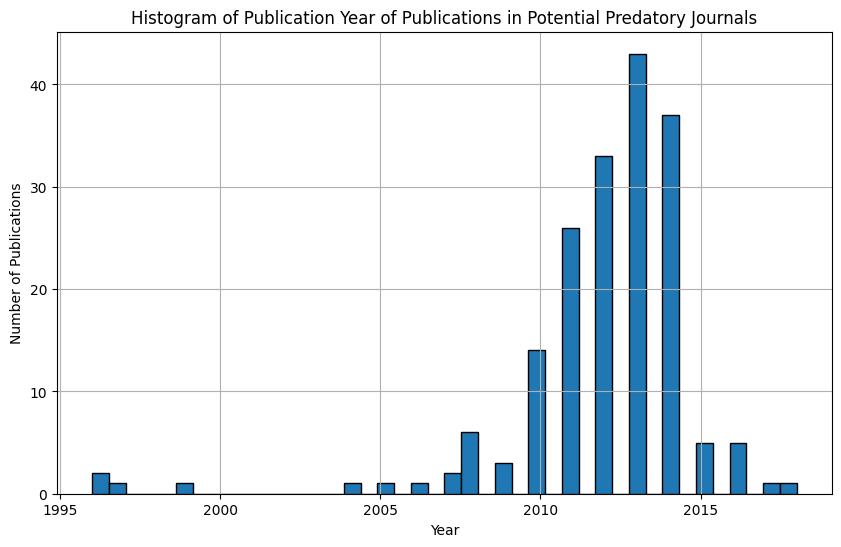

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(article_df['article__publication_year'], bins=42, edgecolor='black')
plt.title('Histogram of Publication Year of Publications in Potential Predatory Journals')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

In [70]:
primary_field = article_df['article__primary_field'].value_counts()
primary_field[:10]

article__primary_field
Mathematics                                     68
Medicine                                        56
Computer Science                                12
Biochemistry, Genetics and Molecular Biology     9
Engineering                                      8
Pharmacology, Toxicology and Pharmaceutics       6
Veterinary                                       5
Physics and Astronomy                            4
Neuroscience                                     3
Decision Sciences                                3
Name: count, dtype: int64

In [71]:
primary_topic = article_df['article__primary_topic'].value_counts()
primary_topic[:10]

article__primary_topic
Anomalous Diffusion Modeling and Analysis                                  25
Theory and Applications of Fractional Differential Equations                8
Fixed Point Theorems in Metric Spaces                                       6
Adverse Drug Reactions and Pharmacovigilance                                6
Iterative Algorithms for Nonlinear Operators and Optimization               5
Animal Research Studies                                                     5
Stability of Functional Equations in Mathematical Analysis                  5
Statistical Convergence in Approximation Theory and Functional Analysis     4
Matrix Inequalities and Geometric Means                                     4
Polypharmacy and Inappropriate Medication Use in Elderly                    4
Name: count, dtype: int64

In [73]:
article_df['article__is_retracted'].value_counts()

article__is_retracted
False    183
Name: count, dtype: int64